# Figure 2

This notebook produces the subplots necessary for Figure 2 of the manuscript. Plots are stored in the `assets` subfolder.

In [99]:
import stylia
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections
from stylia.colors.colors import NamedColors, ContinuousColorMap
from stylia import TWO_COLUMNS_WIDTH

named_colors = NamedColors()

## Cumulative plot by similarity

This plot simply calculates the number of CHEESE hits by similarity threshold.

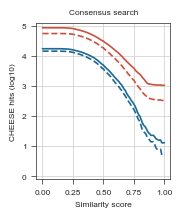

In [137]:
def cumulative_points(values):
    x = np.arange(0, 1.01, 0.01)
    y = []
    for x_ in x:
        y += [np.sum(values >= x_)]
    return np.array(y)

df = pd.read_csv("../results/cheese_popular_hits.csv")
cumulative_points(df["consensus_max_score"])

x = np.arange(0, 1.01, 0.01)
ye = cumulative_points(df[df["database"] == "enamine-real"]["consensus_max_score"])
yz = cumulative_points(df[df["database"] == "zinc15"]["consensus_max_score"])

fig, axs = stylia.create_figure(
    1, 1, width=TWO_COLUMNS_WIDTH * 0.25, height=TWO_COLUMNS_WIDTH * 0.3
)
ax = axs.next()
ax.plot(x, np.log10(ye), label="Enamine REAL", color=named_colors.blue, lw=1.2)
ax.plot(x, np.log10(ye + yz), label="ZINC", color=named_colors.red, lw=1.2)

df = pd.read_csv("../results/cheese_popular_hits_flat.csv")
cumulative_points(df["consensus_max_score"])

x = np.arange(0, 1.01, 0.01)
ye = cumulative_points(df[df["database"] == "enamine-real"]["consensus_max_score"])
yz = cumulative_points(df[df["database"] == "zinc15"]["consensus_max_score"])
ax.plot(x, np.log10(ye), label="Enamine REAL", color=named_colors.blue, lw=1.2, linestyle="--")
ax.plot(x, np.log10(ye + yz), label="ZINC", color=named_colors.red, lw=1.2, linestyle="--")

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.1, 5.1)
stylia.label(
    ax,
    title="Consensus search",
    xlabel="Similarity score",
    ylabel="CHEESE hits (log10)",
)
stylia.save_figure("../figures/f2_a.png")

## CHEESE search aggregates

This panel shows aggregate data from the CHEESE search results. This is a complex plot that will allow us to discuss the differences between querying with different types of CHEESE similarities.

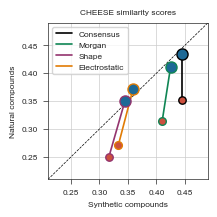

In [68]:
df = pd.read_csv("../results/cheese_search_aggregate.csv")

df_syn = df[df["category"] == "synthetic"]
df_nat = df[df["category"] == "natural"]

fig, axs = stylia.create_figure(
    1, 1, width=TWO_COLUMNS_WIDTH * 0.3, height=TWO_COLUMNS_WIDTH * 0.3
)

ax = axs.next()

statistic = "median"

df_syn = df[df["category"] == "synthetic"]
df_nat = df[df["category"] == "natural"]
df_znc_syn = df_syn[df_syn["database"] == "zinc15"]
df_znc_nat = df_nat[df_nat["database"] == "zinc15"]
df_ena_syn = df_syn[df_syn["database"] == "enamine-real"]
df_ena_nat = df_nat[df_nat["database"] == "enamine-real"]

named_colors = NamedColors()

database_colors = {"zinc15": named_colors.blue, "enamine-real": named_colors.red}
search_type_colors = {
    "consensus": named_colors.black,
    "morgan": named_colors.green,
    "espsim_shape": named_colors.purple,
    "espsim_electrostatic": named_colors.orange,
}

search_type_syns = {
    "consensus": "Consensus",
    "morgan": "Morgan",
    "espsim_shape": "Shape",
    "espsim_electrostatic": "Electrostatic",
}

ax.plot([0, 1], [0, 1], color="black", linestyle="--")

categories = ["synthetic", "natural"]
databases = ["zinc15", "enamine-real"]
search_types = ["consensus", "morgan", "espsim_shape", "espsim_electrostatic"]
for s in search_types:
    edge_x = []
    edge_y = []
    for d in databases:
        db = df[df["database"] == d]
        db = db[db["search_type"] == s]
        dx = db[db["category"] == categories[0]]
        dy = db[db["category"] == categories[1]]
        size = np.sqrt(np.sum(db["counts"]))*0.2
        ax.scatter(
            dx[statistic],
            dy[statistic],
            color=database_colors[d],
            edgecolors=search_type_colors[s],
            zorder=1000,
            s=size,
        )
        edge_x += [dx[statistic]]
        edge_y += [dy[statistic]]
    ax.plot(edge_x, edge_y, color=search_type_colors[s], lw=1.2, label=search_type_syns[s])

ax.legend()
ax.set_xlim(0.21, 0.49)
ax.set_ylim(0.21, 0.49)
stylia.label(
    ax,
    title="CHEESE similarity scores",
    xlabel="Synthetic compounds",
    ylabel="Natural compounds",
)
stylia.save_figure("../figures/f2_b.png")

# CHEESE popular hits in the top 100

This plot analyses the hits and measures the number of natural products and synthetic products similar to them.

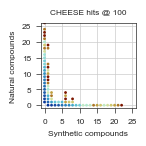

In [138]:
df = pd.read_csv("../results/cheese_popular_hits_flat.csv")
df = df[(df["consensus_syn_hits"] > 0) | (df["consensus_nat_hits"] > 0)]

fig, axs = stylia.create_figure(1, 1, width=TWO_COLUMNS_WIDTH * 0.2, height= TWO_COLUMNS_WIDTH * 0.2)
ax = axs.next()

values = "consensus_syn_hits", "consensus_nat_hits"

x, y = df[values[0]].tolist(), df[values[1]].tolist()
counts = collections.defaultdict(int)
for x_, y_ in zip(x, y):
    counts[(x_, y_)] += 1

x = []
y = []
z = []
for k, v in counts.items():
    x += [k[0]]
    y += [k[1]]
    z += [v]

cmap = ContinuousColorMap()
cmap.fit(z)
colors = cmap.transform(z)

ax.scatter(x, y, color=colors, s=1)
ax.set_xticks(np.arange(0, 26, 5))
ax.set_yticks(np.arange(0, 26, 5))
ax.set_xlim(-1, 26)
ax.set_ylim(-1, 26)
plt.tight_layout()

stylia.label(ax, title="CHEESE hits @ 100", xlabel="Synthetic compounds", ylabel="Natural compounds")
plt.tight_layout()
stylia.save_figure("../figures/f2_c.png")

## Ranked molecules

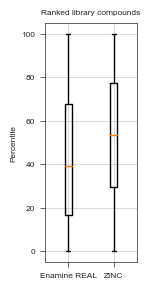

In [158]:
df = pd.read_csv("../results/cheese_search_flat_ranked.csv")

fig, axs = stylia.create_figure(1, 1, width=TWO_COLUMNS_WIDTH * 0.2, height= TWO_COLUMNS_WIDTH * 0.4)
ax = axs.next()

ax.boxplot(x=[df[df["database"] == "enamine-real"]["tot_rank"], df[df["database"] == "zinc15"]["tot_rank"]], labels=["Enamine REAL", "ZINC"])
stylia.label(ax, title="Ranked library compounds", ylabel="Percentile", xlabel="")
plt.tight_layout()

stylia.save_figure("../figures/f2_d.png")

## 2D Projection

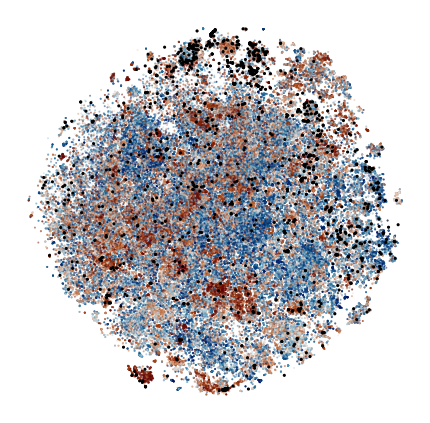

In [214]:
dp = pd.read_csv("../results/chemical_space_projection.csv")

fig, axs = stylia.create_figure(1, 1, width=TWO_COLUMNS_WIDTH * 0.6, height= TWO_COLUMNS_WIDTH * 0.6)

ax = axs.next()
ax.set_aspect("equal")

dp_ = dp[dp["category"] == "Manually annotated"]
ax.scatter(dp_["x"], dp_["y"], s=5, edgecolor="none", color=named_colors.black, zorder=100000)

dp_ = dp[dp["category"] == "CHEESE search"]
cmap = ContinuousColorMap("coolwarm")
cmap.fit(dp_["tot_rank"])
colors = cmap.transform(dp_["tot_rank"])
ax.scatter(dp_["x"], dp_["y"], s=2, edgecolor="none", color=colors, zorder=1000, alpha=0.5)
ax.set_axis_off()

cmap = ContinuousColorMap()
stylia.label(ax, title="", xlabel="", ylabel="")

plt.tight_layout()
stylia.save_figure("../figures/f2_e.png")

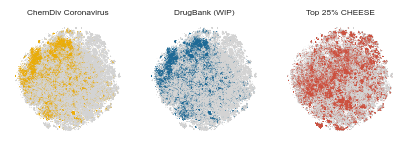

In [210]:
fig, axs = stylia.create_figure(1, 3, width=TWO_COLUMNS_WIDTH * 0.6, height= TWO_COLUMNS_WIDTH * 0.6/3)

ax = axs.next()
ax.set_aspect("equal")
dp_ = dp[dp["category"] == "CHEESE search"]
ax.scatter(dp_["x"], dp_["y"], s=0.1, edgecolor="none", color=named_colors.gray, zorder=1)
dp_ = dp[dp["category"] == "ChemDiv Coronavirus"]
ax.scatter(dp_["x"], dp_["y"], s=0.1, edgecolor="none", color=named_colors.yellow, zorder=10000, alpha=1)
stylia.label(ax, title = "ChemDiv Coronavirus")
ax.set_axis_off()

ax = axs.next()
ax.set_aspect("equal")
dp_ = dp[dp["category"] == "CHEESE search"]
ax.scatter(dp_["x"], dp_["y"], s=0.1, edgecolor="none", color=named_colors.gray, zorder=1)
dp_ = dp[dp["category"] == "ChemDiv Coronavirus"]
ax.scatter(dp_["x"], dp_["y"], s=0.1, edgecolor="none", color=named_colors.blue, zorder=10000, alpha=1)
stylia.label(ax, title = "DrugBank (WIP)")
ax.set_axis_off()

ax = axs.next()
ax.set_aspect("equal")
dp_ = dp[dp["category"] == "CHEESE search"]
ax.scatter(dp_["x"], dp_["y"], s=0.1, edgecolor="none", color=named_colors.gray, zorder=1)
dp_ = dp[(dp["category"] == "CHEESE search") & (dp["tot_rank"] > 75)]
ax.scatter(dp_["x"], dp_["y"], s=0.1, edgecolor="none", color=named_colors.red, zorder=10000, alpha=1)
ax.set_axis_off()
stylia.label(ax, title = "Top 25% CHEESE")

plt.tight_layout()

stylia.save_figure("../figures/f2_f.png")